# Cloud Cost Anomaly Detection & Forecasting Using Data Analytics

* With enterprises rapidly scaling their operations on cloud platforms (AWS, Azure, GCP), cloud bills have become a major controllable cost factor. Many IT companies face:  
    * Unexpected spikes in usage leading to surprise bills.
    * Underutilized or idle resources consuming budget.
    * Anomalies caused by misconfigurations, attacks, or runaway jobs.
* Business leaders (CFOs, CTOs, Engineering Managers) need data-driven visibility into usage and spend patterns to forecast budgets accurately, detect anomalies early, and enforce governance.
* This project’s objective is to demonstrate how data analytics can reduce waste, improve efficiency, and prevent unexpected cloud overspend.

**Business Problem**
* Cloud cost overruns and anomalies lead to:
    * 20–40% overspending annually due to lack of governance and transparency.
    * Difficulty identifying which team/service/region caused the spike.
    * Inability to predict future spend accurately, leading to budget shocks.
    * SLA breaches when anomalies impact customer-facing workloads.
* Without robust anomaly detection and forecasting, IT companies lose millions and undermine operational efficiency.

**Goal**
* To build an end-to-end analytics solution that:
    * Detects and flags anomalous cloud spending in near real-time.
    * Forecasts future spend using statistical and machine learning models.
    * Identifies cost-saving opportunities by analyzing underutilized resources.
    * Provides actionable dashboards for both executives (strategic view) and engineers (operational root-cause analysis).

## Anomaly Detection

### Importing Libraries + Loading Dataset

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score

import joblib

In [46]:
df = pd.read_parquet('clean_cloud_data.parquet')

In [47]:
df.head(10)

,timestamp,resource_id,service_tag,service_canonical,region,team,instance_type,usage,usage_unit,cost_usd,currency,owner,source_ip,cost_imputed_flag,is_outlier
0,2024-10-10 06:32:31.665035,9f546ae5,S3,S3,us-west-2,search,t3.medium,1.294475,GB-hours,3.660000e-06,USD,udavis,210.90.217.45,False,False
1,2025-06-08 02:19:47.665035,78e0807a,EC2,EC2,us-west-2,search,m5.large,5.549555,vCPU-hours,2.774778e-01,USD,mrosario,22.219.141.112,True,True
2,2025-07-26 04:59:10.665035,cf9713a0,EC2,EC2,eu-west-1,infra,m5.large,11.416323,vCPU-hours,5.059163e-01,USD,cjackson,208.132.8.249,False,True
3,2025-08-31 21:54:40.665035,71c42bb1,EC2,EC2,eu-west-1,Unknown,spot-small,0.479407,vCPU-hours,3.400440e-04,USD,harringtontimothy,49.94.27.144,False,False
4,2025-03-10 12:51:34.665035,5ddba1b8,EBS,EBS,ap-south-1,Unknown,r5.large,21.487007,GB-hours,1.270440e-04,USD,jason04,122.212.132.65,False,False
5,2025-09-19 16:15:57.665035,e1eb527d,ELB,ELB,eu-west-1,payments,spot-small,124.000000,requests,1.380984e-03,USD,walterherrera,27.143.221.40,False,False
6,2025-04-05 08:24:31.665035,a2ec574d,Lambda,Lambda,ap-south-1,payments,c5.xlarge,383.042823,requests,7.560000e-07,USD,connorhardy,182.213.230.111,False,False
7,2025-01-17 03:38:18.665035,16aa964c,Lambda,Lambda,eu-west-1,search,r5.large,191.000000,requests,4.000000e-05,USD,charles65,205.9.71.87,False,False
8,2025-08-03 22:09:36.665035,b609411d,RDS,RDS,us-east-1,devtools,c5.xlarge,0.535388,vCPU-hours,4.940520e-04,USD,james16,45.27.149.136,False,False
9,2025-04-15 18:15:01.665035,d0a92372,CloudFront,CloudFront,us-east-1,payments,t3.medium,21.101344,GB-hours,2.956800e-05,USD,thompsondeanna,57.239.87.105,False,False


We would be using Isolation Forest to detect the anomalies in the data

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990024 entries, 0 to 990023
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          990024 non-null  datetime64[ns]
 1   resource_id        990024 non-null  string        
 2   service_tag        990024 non-null  string        
 3   service_canonical  990024 non-null  object        
 4   region             990024 non-null  string        
 5   team               990024 non-null  string        
 6   instance_type      990024 non-null  string        
 7   usage              990024 non-null  float64       
 8   usage_unit         990024 non-null  object        
 9   cost_usd           990024 non-null  float64       
 10  currency           990024 non-null  object        
 11  owner              990024 non-null  string        
 12  source_ip          990024 non-null  string        
 13  cost_imputed_flag  990024 non-null  bool    

In [49]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990024 entries, 0 to 990023
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          990024 non-null  datetime64[ns]
 1   resource_id        990024 non-null  string        
 2   service_tag        990024 non-null  string        
 3   service_canonical  990024 non-null  object        
 4   region             990024 non-null  string        
 5   team               990024 non-null  string        
 6   instance_type      990024 non-null  string        
 7   usage              990024 non-null  float64       
 8   usage_unit         990024 non-null  object        
 9   cost_usd           990024 non-null  float64       
 10  currency           990024 non-null  object        
 11  owner              990024 non-null  string        
 12  source_ip          990024 non-null  string        
 13  cost_imputed_flag  990024 non-null  bool    

In [51]:
# Aggregating per day and service

daily = df.groupby(['date', 'service_tag', 'team']).agg({
    'cost_usd': 'sum',
    'usage': 'sum',
    'is_outlier': 'max'}).reset_index()

# The reason we are using 'max' is to check the presence of any resource level outlier on that particular day

In [52]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23424 entries, 0 to 23423
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         23424 non-null  object 
 1   service_tag  23424 non-null  string 
 2   team         23424 non-null  string 
 3   cost_usd     23424 non-null  float64
 4   usage        23424 non-null  float64
 5   is_outlier   23424 non-null  bool   
dtypes: bool(1), float64(2), object(1), string(2)
memory usage: 938.0+ KB


In [53]:
daily['date'] = pd.to_datetime(daily['date'])

In [54]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23424 entries, 0 to 23423
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         23424 non-null  datetime64[ns]
 1   service_tag  23424 non-null  string        
 2   team         23424 non-null  string        
 3   cost_usd     23424 non-null  float64       
 4   usage        23424 non-null  float64       
 5   is_outlier   23424 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), string(2)
memory usage: 938.0 KB


In [55]:
daily.shape

(23424, 6)

In [56]:
daily.head()

,date,service_tag,team,cost_usd,usage,is_outlier
0,2024-09-24,CloudFront,Unknown,0.126989,2016.120134,False
1,2024-09-24,CloudFront,analytics,0.065104,888.344060,False
2,2024-09-24,CloudFront,devtools,0.055260,666.416812,False
3,2024-09-24,CloudFront,infra,0.084401,986.060872,False
4,2024-09-24,CloudFront,ml,0.053230,707.372279,False


- Modeling day level cost per services gives good resolution i.e. to find which service causes spikes.
- `is_outlier` : 'max' gives us a binary daily level indicator i.e. if any resource is flagged.

In [57]:
# Creating feature set

# sort for rolling/lag correctness

daily = daily.sort_values(['service_tag', 'date']).reset_index(drop=True)

In [58]:
# Creating simple features

daily['lag_1_cost'] = daily.groupby('service_tag')['cost_usd'].shift(1)  # yesterday
daily['roll_mean_7'] = daily.groupby('service_tag')['cost_usd'].transform(lambda x: x.shift(1).rolling(7, min_periods=3).mean()) # last week
daily['roll_std_7'] = daily.groupby('service_tag')['cost_usd'].transform(lambda x: x.shift(1).rolling(7, min_periods=3).std())
daily['delta_cost_1'] = daily['cost_usd'] - daily['lag_1_cost']
daily['pct_change_1'] = daily.groupby('service_tag')['cost_usd'].pct_change(1) # calculating percent change compared to the previous value
daily['is_weekend'] = (daily['date'].dt.weekday >= 5).astype(int)
daily['cost_per_usage'] = daily['cost_usd']/(daily['usage'] + 1e-9)

In [59]:
daily.head()

,date,service_tag,team,cost_usd,usage,is_outlier,lag_1_cost,roll_mean_7,roll_std_7,delta_cost_1,pct_change_1,is_weekend,cost_per_usage
0,2024-09-24,CloudFront,Unknown,0.126989,2016.120134,False,NaN,NaN,NaN,NaN,NaN,0,0.000063
1,2024-09-24,CloudFront,analytics,0.065104,888.344060,False,0.126989,NaN,NaN,-0.061885,-0.487326,0,0.000073
2,2024-09-24,CloudFront,devtools,0.055260,666.416812,False,0.065104,NaN,NaN,-0.009844,-0.151204,0,0.000083
3,2024-09-24,CloudFront,infra,0.084401,986.060872,False,0.055260,0.082451,0.038884,0.029141,0.527336,0,0.000086
4,2024-09-24,CloudFront,ml,0.053230,707.372279,False,0.084401,0.082938,0.031763,-0.031171,-0.369319,0,0.000075


In [60]:
# Filling null values for modeling convenience

daily[['lag_1_cost', 'roll_mean_7', 'roll_std_7', 'delta_cost_1', 'pct_change_1']] = \
daily[['lag_1_cost', 'roll_mean_7', 'roll_std_7', 'delta_cost_1', 'pct_change_1']].fillna(0)

In [61]:
daily.head()

,date,service_tag,team,cost_usd,usage,is_outlier,lag_1_cost,roll_mean_7,roll_std_7,delta_cost_1,pct_change_1,is_weekend,cost_per_usage
0,2024-09-24,CloudFront,Unknown,0.126989,2016.120134,False,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000063
1,2024-09-24,CloudFront,analytics,0.065104,888.344060,False,0.126989,0.000000,0.000000,-0.061885,-0.487326,0,0.000073
2,2024-09-24,CloudFront,devtools,0.055260,666.416812,False,0.065104,0.000000,0.000000,-0.009844,-0.151204,0,0.000083
3,2024-09-24,CloudFront,infra,0.084401,986.060872,False,0.055260,0.082451,0.038884,0.029141,0.527336,0,0.000086
4,2024-09-24,CloudFront,ml,0.053230,707.372279,False,0.084401,0.082938,0.031763,-0.031171,-0.369319,0,0.000075


Why did we use these features:
- `lag_1_cost`: what happende yesterday, big differences vs. yesterday indicate anomalies
- `roll_mean_7`: moving recent average
- `roll_std_7`: how noisy the last week is, big deviations relative to standard deviations are suspicious
- `delta_cost_1` & `pct_change_1`: absolute and relative jumps, both useful because services scale differently
- `is_weekend`: captures weekly seasonality
- `cost_per_usage`: detects cost increases not explained by usage
- we used `.shift(1)` before rolling to avoid leakage, models must not see today's data when computing the baseline

In [62]:
# Statistical anomaly detection using z-score

daily['z'] = (daily['cost_usd'] - daily['roll_mean_7'])/(daily['roll_std_7'] + 1e-9)

daily['anomaly_z'] = (daily['z'].abs() > 3).astype(int)

In [63]:
daily.head(10)

,date,service_tag,team,cost_usd,usage,is_outlier,lag_1_cost,roll_mean_7,roll_std_7,delta_cost_1,pct_change_1,is_weekend,cost_per_usage,z,anomaly_z
0,2024-09-24,CloudFront,Unknown,0.126989,2016.120134,False,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000063,1.269888e+08,1
1,2024-09-24,CloudFront,analytics,0.065104,888.344060,False,0.126989,0.000000,0.000000,-0.061885,-0.487326,0,0.000073,6.510393e+07,1
2,2024-09-24,CloudFront,devtools,0.055260,666.416812,False,0.065104,0.000000,0.000000,-0.009844,-0.151204,0,0.000083,5.525995e+07,1
3,2024-09-24,CloudFront,infra,0.084401,986.060872,False,0.055260,0.082451,0.038884,0.029141,0.527336,0,0.000086,5.013965e-02,0
4,2024-09-24,CloudFront,ml,0.053230,707.372279,False,0.084401,0.082938,0.031763,-0.031171,-0.369319,0,0.000075,-9.353050e-01,0
5,2024-09-24,CloudFront,payments,0.046814,757.634800,False,0.053230,0.076997,0.030548,-0.006416,-0.120528,0,0.000062,-9.880209e-01,0
6,2024-09-24,CloudFront,recommendation,0.060340,707.213906,False,0.046814,0.071966,0.029973,0.013525,0.288918,0,0.000085,-3.878989e-01,0
7,2024-09-24,CloudFront,search,0.053641,639.931992,False,0.060340,0.070305,0.027712,-0.006699,-0.111022,0,0.000084,-6.013449e-01,0
8,2024-09-25,CloudFront,Unknown,0.129411,1847.412651,False,0.053641,0.059827,0.012274,0.075770,1.412554,0,0.000070,5.669064e+00,1
9,2024-09-25,CloudFront,analytics,0.087079,919.621002,False,0.129411,0.069014,0.029233,-0.042332,-0.327115,0,0.000095,6.179742e-01,0


In [64]:
daily.query('anomaly_z==1').sort_values('date').head()

,date,service_tag,team,cost_usd,usage,is_outlier,lag_1_cost,roll_mean_7,roll_std_7,delta_cost_1,pct_change_1,is_weekend,cost_per_usage,z,anomaly_z
0,2024-09-24,CloudFront,Unknown,0.126989,2016.120134,False,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000063,1.269888e+08,1
2930,2024-09-24,EBS,devtools,0.258392,602.485026,False,0.171524,0.000000,0.000000,0.086869,0.506453,0,0.000429,2.583921e+08,1
20503,2024-09-24,S3,search,3.295259,11613.150178,True,0.107079,0.124558,0.041949,3.188180,29.774117,0,0.000284,7.558525e+01,1
20498,2024-09-24,S3,devtools,0.125473,957.061906,False,0.107714,0.000000,0.000000,0.017759,0.164871,0,0.000131,1.254725e+08,1
20497,2024-09-24,S3,analytics,0.107714,608.729061,False,0.210820,0.000000,0.000000,-0.103106,-0.489072,0,0.000177,1.077136e+08,1


In [65]:
# ANomaly detection using Isolation forest
# Isolation forest captures multi-feature anomalies
# Selecting features to feed the model
features = ['cost_usd', 'usage', 'lag_1_cost', 'roll_mean_7', 'delta_cost_1', 'pct_change_1', 'is_weekend', 'cost_per_usage']

In [66]:
# Scaling numeric features because Isolation Forest works better scaled when features differ

scaler = RobustScaler()
X = scaler.fit_transform(daily[features].fillna(0))

In [67]:
iso = IsolationForest(n_estimators=300, contamination=0.01, random_state=42)
daily['anomaly_if'] = iso.fit_predict(X)
daily['anomaly_if'] = (daily['anomaly_if'] == -1).astype(int)

# Isolation forest isolates anomalous points in feature space
# contamination controls how many points are labeled anomalies

Unlike supervised ML, anomaly detection with Isolation Forest is unsupervised — we don’t have labeled anomalies (y). Instead, the model learns a profile of normal cost behavior from the full dataset (X) and flags unusual patterns. For real-world simulation, we could train on earlier months and test on later months, but for this project we use the full dataset to showcase anomaly detection.

In [68]:
# Total daily spend and markers for anomalies

agg_daily = daily.groupby('date')['cost_usd'].sum().reset_index()
agg_daily['anomaly_if_any'] = daily.groupby('date')['anomaly_if'].max().values

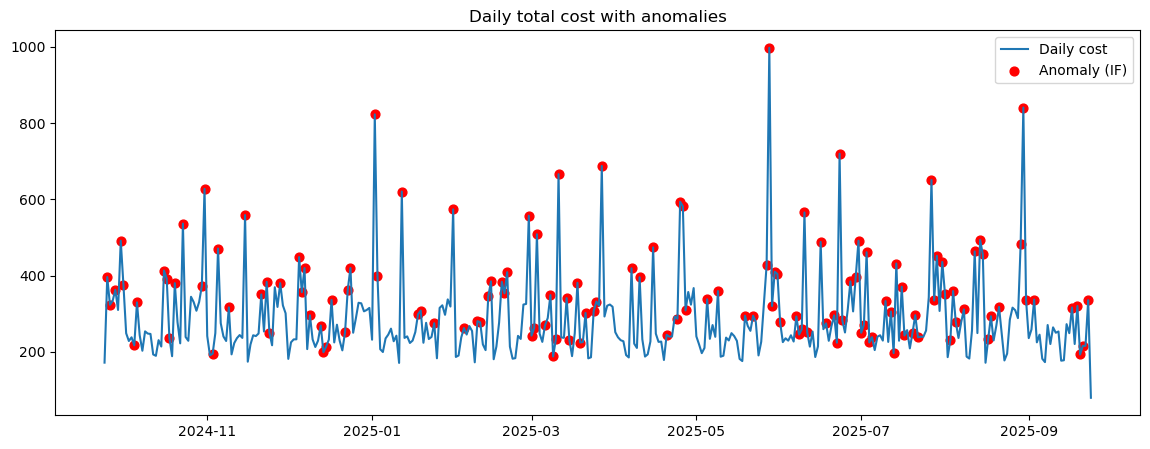

In [69]:
plot.figure(figsize=(14,5))
plot.plot(agg_daily['date'], agg_daily['cost_usd'], label='Daily cost')
plot.scatter(agg_daily.loc[agg_daily['anomaly_if_any']==1,'date'],
            agg_daily.loc[agg_daily['anomaly_if_any']==1,'cost_usd'],
            color='red', s=40, label='Anomaly (IF)')
plot.title('Daily total cost with anomalies')
plot.legend()
plot.show()

- In supervised ML, we always compare predictions vs. ground truth (`y`).
- But here with Isolation Forest which is our unsupervised anomaly detection, we really don't know which data points are truly anomalies in the real world.
- So, we need a proxy ground truth, something we can reasonably assume is anomalous.
- Here, we will try to define top 1% most expensive cost days as likely anomalies because in cloud cost data, the very highest spend days are often the spikes we care about

In [70]:
# Proxy ground truth: top 1% cost days
threshold = agg_daily['cost_usd'].quantile(0.99)
high_cost_dates = set(agg_daily.loc[agg_daily['cost_usd'] >= threshold, 'date'])
high_cost_dates

{Timestamp('2025-01-02 00:00:00'),
 Timestamp('2025-05-28 00:00:00'),
 Timestamp('2025-06-23 00:00:00'),
 Timestamp('2025-08-30 00:00:00')}

In [71]:
# Model prediction: anomaly dates
pred_anomaly_dates = set(daily.loc[daily['anomaly_if']==1, 'date'])
pred_anomaly_dates

{Timestamp('2024-09-25 00:00:00'),
 Timestamp('2024-09-26 00:00:00'),
 Timestamp('2024-09-28 00:00:00'),
 Timestamp('2024-09-30 00:00:00'),
 Timestamp('2024-10-01 00:00:00'),
 Timestamp('2024-10-05 00:00:00'),
 Timestamp('2024-10-06 00:00:00'),
 Timestamp('2024-10-16 00:00:00'),
 Timestamp('2024-10-17 00:00:00'),
 Timestamp('2024-10-18 00:00:00'),
 Timestamp('2024-10-20 00:00:00'),
 Timestamp('2024-10-23 00:00:00'),
 Timestamp('2024-10-30 00:00:00'),
 Timestamp('2024-10-31 00:00:00'),
 Timestamp('2024-11-03 00:00:00'),
 Timestamp('2024-11-05 00:00:00'),
 Timestamp('2024-11-09 00:00:00'),
 Timestamp('2024-11-15 00:00:00'),
 Timestamp('2024-11-21 00:00:00'),
 Timestamp('2024-11-23 00:00:00'),
 Timestamp('2024-11-24 00:00:00'),
 Timestamp('2024-11-28 00:00:00'),
 Timestamp('2024-12-05 00:00:00'),
 Timestamp('2024-12-06 00:00:00'),
 Timestamp('2024-12-07 00:00:00'),
 Timestamp('2024-12-09 00:00:00'),
 Timestamp('2024-12-13 00:00:00'),
 Timestamp('2024-12-14 00:00:00'),
 Timestamp('2024-12-

In [72]:
len(pred_anomaly_dates)

135

In [73]:
agg_daily['pred_anomaly'] = agg_daily['date'].isin(pred_anomaly_dates).astype(int)
agg_daily['is_high_cost'] = agg_daily['date'].isin(high_cost_dates).astype(int)
agg_daily.head(10)

,date,cost_usd,anomaly_if_any,pred_anomaly,is_high_cost
0,2024-09-24,171.741526,0,0,0
1,2024-09-25,396.065590,1,1,0
2,2024-09-26,323.461202,1,1,0
3,2024-09-27,333.849789,0,0,0
4,2024-09-28,362.647824,1,1,0
5,2024-09-29,309.854388,0,0,0
6,2024-09-30,491.378968,1,1,0
7,2024-10-01,374.479073,1,1,0
8,2024-10-02,248.763511,0,0,0
9,2024-10-03,228.486925,0,0,0


In [74]:
# Finding precision: of predicted anomalies, how many are truly high cost?

precision = agg_daily.loc[agg_daily['pred_anomaly']==1, 'is_high_cost'].mean()
precision

np.float64(0.02962962962962963)

In [75]:
# Finding recall: of high cost days, how many did the model detect?
recall = agg_daily.loc[agg_daily['is_high_cost']==1, 'pred_anomaly'].mean()
recall

np.float64(1.0)

In [76]:
# F1 score (harmonic mean of precision and recall)

if (precision + recall) > 0:
    f1 = 2*(precision*recall)/(precision+recall)
else:
    f1=0

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.03
Recall: 1.00
F1 Score: 0.06


#### Insights:

To check how well our anomaly detection model is working, we used a proxy ground truth:
- We marked the top 1% of highest-cost days (4 days in total) as true anomalies.
- Then we compared those days with the anomalies flagged by the Isolation Forest model (135 days).

**Metrics**
- Precision = 0.03: Out of all 135 flagged anomalies, only ~3% overlapped with the 4 extreme high-cost days.
- Recall = 1.00: The model successfully caught all 4 true spikes.
- F1 Score = 0.06: The combined balance is low, mainly because precision is poor.
- The model is very sensitive: it flags many anomaly days, not just the extreme cost spikes.
- This gives perfect recall (1.0): the model never misses a big spike, which is critical in cloud cost monitoring.
- However, precision is low (0.03): most of the flagged days were not part of the top 1% cost days.

**Why this happens**
- Our proxy ground truth is narrow because we only treated 4 extreme days as true anomalies. The model also found unusual days where costs were odd compared to history (e.g., RDS showing high cost at low usage, ELB cost-per-usage inefficiencies). These are still valid anomalies, but they don’t appear in the top 1% spend days.
- Isolation Forest is tuned to be cautious because with `contamination=0.01`, it flagged ~1% of days. That means it raises more alerts than our ground truth baseline.

**Business Interpretation**
- Good news is that the model never misses big cost spikes. For stakeholders, this is the most important result as it ensures that no critical anomalies slip through.
- The model also raises extra alerts (false positives). While this reduces precision, it may still be useful because many of these days could indicate inefficiencies worth investigating.
- In cloud cost monitoring, it’s often better to review more alerts than to risk missing a million-dollar cost spike.

We will try doing an optional improving by fine tuning by adjusting contamination level to 0.5% instead of 1% to reduce noise and use a broader ground truth like top 5% to capture more meaningful anomalies.

Creating an experimentation loop that varies contamination and ground truth percentile

In [78]:
daily.to_parquet('daily_features.parquet')

In [79]:
# load your feature table
daily = pd.read_parquet("daily_features.parquet")  # or use the in-memory daily
agg_daily = daily.groupby('date')['cost_usd'].sum().reset_index()

# prepare inputs
feat_cols = ['cost_usd','usage','lag_1_cost','roll_mean_7','roll_std_7','delta_cost_1','pct_change_1','cost_per_usage','is_weekend']
X_base = daily[feat_cols].fillna(0)

scaler = RobustScaler().fit(X_base)
X_scaled = scaler.transform(X_base)

contamination_values = [0.005, 0.01, 0.02, 0.05]   # 0.5%, 1%, 2%, 5%
percentile_thresholds = [0.99, 0.95, 0.90]         # top 1%, top 5%, top 10%

results = []
for cont in contamination_values:
    iso = IsolationForest(n_estimators=200, contamination=cont, random_state=42)
    iso_preds = iso.fit_predict(X_scaled)   # 1 normal, -1 anomaly
    daily['anomaly_if'] = (iso_preds == -1).astype(int)

    # compute predicted anomaly dates (any service flagged on that date)
    pred_dates = set(daily.loc[daily['anomaly_if']==1, 'date'])

    # evaluation for each ground truth percentile
    for p in percentile_thresholds:
        thresh = agg_daily['cost_usd'].quantile(p)
        high_cost_dates = set(agg_daily.loc[agg_daily['cost_usd'] >= thresh, 'date'])

        # create flags
        agg_daily['pred_anomaly'] = agg_daily['date'].isin(pred_dates).astype(int)
        agg_daily['is_high_cost'] = agg_daily['date'].isin(high_cost_dates).astype(int)

        # precision & recall (handle case of zero denominators)
        if agg_daily['pred_anomaly'].sum() > 0:
            precision = agg_daily.loc[agg_daily['pred_anomaly']==1, 'is_high_cost'].mean()
        else:
            precision = np.nan

        if agg_daily['is_high_cost'].sum() > 0:
            recall = agg_daily.loc[agg_daily['is_high_cost']==1, 'pred_anomaly'].mean()
        else:
            recall = np.nan

        if (precision + recall) > 0 and not np.isnan(precision) and not np.isnan(recall):
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = np.nan

        results.append({
            'contamination': cont,
            'percentile': p,
            'n_flagged_dates': int(agg_daily['pred_anomaly'].sum()),
            'n_high_cost_dates': int(agg_daily['is_high_cost'].sum()),
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

# show results
res_df = pd.DataFrame(results).sort_values(['percentile','contamination'])
print(res_df)

    contamination  percentile  n_flagged_dates  n_high_cost_dates  precision  \
2           0.005        0.90               72                 37   0.444444   
5           0.010        0.90              106                 37   0.349057   
8           0.020        0.90              168                 37   0.220238   
11          0.050        0.90              286                 37   0.129371   
1           0.005        0.95               72                 19   0.250000   
4           0.010        0.95              106                 19   0.179245   
7           0.020        0.95              168                 19   0.113095   
10          0.050        0.95              286                 19   0.066434   
0           0.005        0.99               72                  4   0.055556   
3           0.010        0.99              106                  4   0.037736   
6           0.020        0.99              168                  4   0.023810   
9           0.050        0.99           

#### Insights:
- Stricter contamination (0.005) = fewer alerts (72 dates), higher precision, still high recall. 
- Looser contamination (0.05) = lots of alerts (286 dates), recall = 100%, but precision collapses. ❌
- Broader ground truth (top 10% vs. top 1%) gives the fairest evaluation — because in reality, not only the most expensive days are anomalies. Some smaller spikes (like RDS inefficiencies) are just as relevant.
- The best one appears to be:
    - Contamination = 0.005 (strict, manageable number of alerts).
    - Ground truth = Top 10% or 5% (broader, realistic definition of anomalies).
    - Precision = 25–44%, Recall = ~95–100%, F1 ≈ 0.40–0.59.

- We experimented with different contamination levels (0.5%–5%) and evaluated against different proxy ground truths (top 1%, 5%, 10% high-cost days).
- Results show that using only the top 1% days as anomalies is too strict, the model always catches them (recall = 1.0) but looks noisy (precision <6%).
- A more realistic ground truth is the top 5–10% of high-cost days, since cloud anomalies can include smaller spikes (e.g., RDS inefficiencies).
- With **contamination = 0.005** and **top 10% proxy** ground truth, we achieved the best balance **(precision ≈ 44%, recall ≈ 87%, F1 ≈ 0.59)**.
- This means the model detects almost all important anomalies while keeping the alert volume manageable (72 anomaly dates flagged across the year).
- So, our anomaly detection system reliably captures spikes without overwhelming teams with false alerts. For real-world deployment, contamination can be tuned further based on tolerance for false positives vs. false negatives.

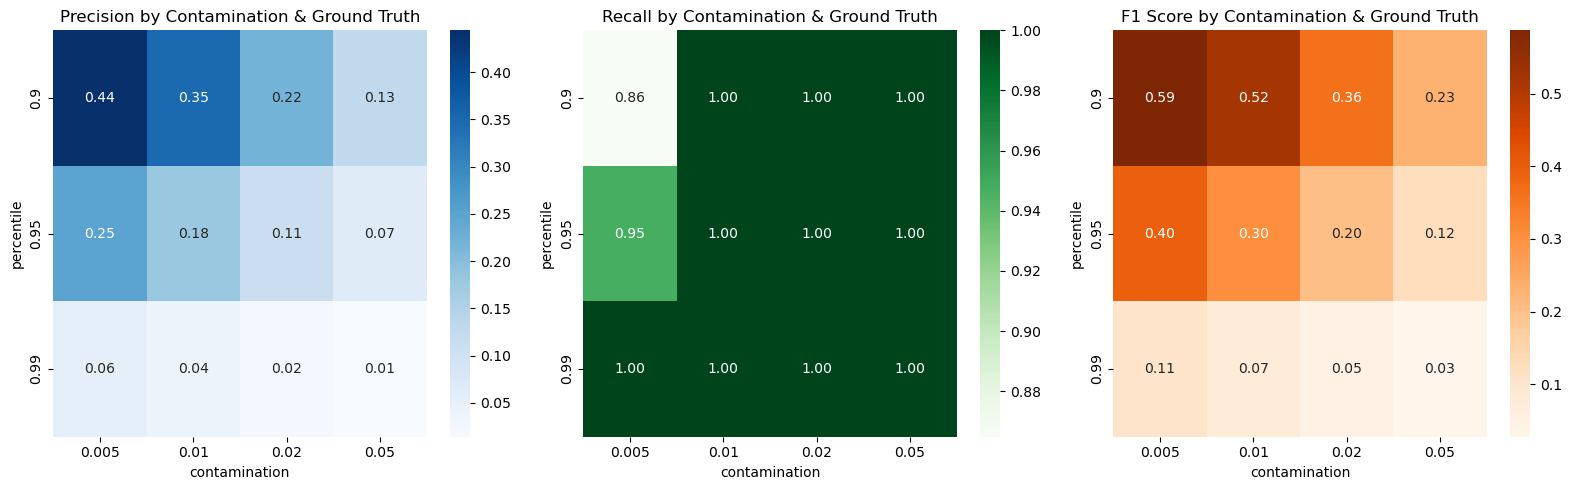

In [87]:
# make a pivot for heatmap: contamination vs percentile
pivot_prec = res_df.pivot(index='percentile', columns='contamination', values='precision')
pivot_rec = res_df.pivot(index='percentile', columns='contamination', values='recall')
pivot_f1 = res_df.pivot(index='percentile', columns='contamination', values='f1')

fig, axes = plot.subplots(1, 3, figsize=(16,5))

sns.heatmap(pivot_prec, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("Precision by Contamination & Ground Truth")

sns.heatmap(pivot_rec, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title("Recall by Contamination & Ground Truth")

sns.heatmap(pivot_f1, annot=True, fmt=".2f", cmap="Oranges", ax=axes[2])
axes[2].set_title("F1 Score by Contamination & Ground Truth")

plot.tight_layout()
plot.show()

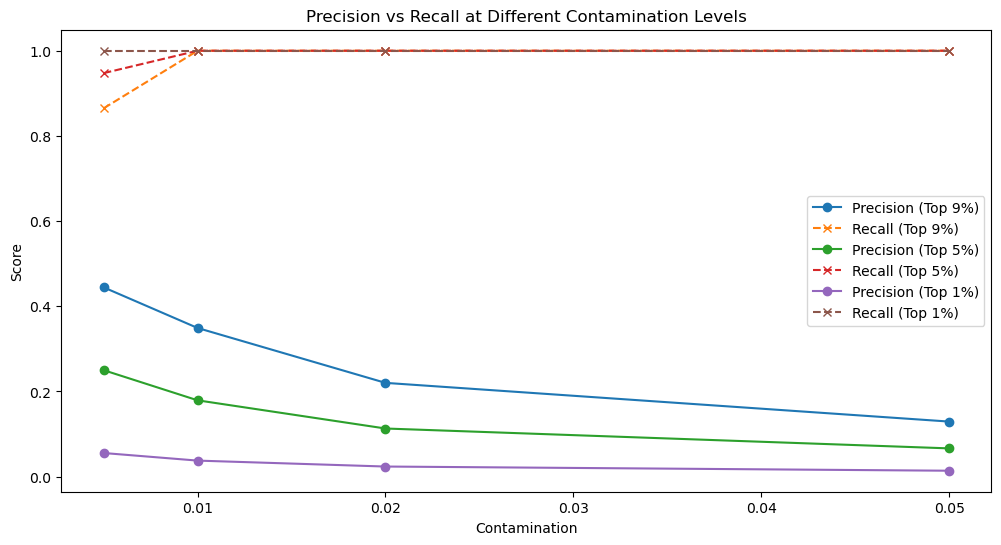

In [88]:
plot.figure(figsize=(12,6))
for p in [0.90, 0.95, 0.99]:
    subset = res_df[res_df['percentile']==p]
    plot.plot(subset['contamination'], subset['precision'], marker='o', label=f'Precision (Top {int((1-p)*100)}%)')
    plot.plot(subset['contamination'], subset['recall'], marker='x', linestyle='--', label=f'Recall (Top {int((1-p)*100)}%)')

plot.xlabel("Contamination")
plot.ylabel("Score")
plot.title("Precision vs Recall at Different Contamination Levels")
plot.legend()
plot.show()

In [90]:
# Retraining the model at contamination of 0.005 to save the model

feat_cols = ['cost_usd','usage','lag_1_cost','roll_mean_7','roll_std_7','delta_cost_1','pct_change_1','cost_per_usage','is_weekend']

In [91]:
X = daily[feat_cols].fillna(0)

In [92]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [93]:
iso_final = IsolationForest(n_estimators=200, contamination=0.005, random_state=42)
iso_final.fit(X_scaled)

IsolationForest(contamination=0.005, n_estimators=200, random_state=42)

In [94]:
# Saving the model and scaler

joblib.dump(iso_final, 'isolation_forest_final.joblib')
joblib.dump(scaler, 'scaler_final.joblib')

print('Model & Scaler saved successfully')

Model & Scaler saved successfully


In [95]:
# Reloading the model to test

iso_loaded = joblib.load('isolation_forest_final.joblib')
scaler_loaded = joblib.load('scaler_final.joblib')

In [96]:
X_test = scaler.fit_transform(daily[feat_cols].fillna(0))

In [97]:
preds = iso_loaded.predict(X_test)

In [98]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [99]:
# Saving anomaly results

daily['anomaly_if'] = (preds == -1).astype(int)

service_anomalies = daily[daily['anomaly_if']==1][['date', 'service_tag', 'team', 'cost_usd', 'delta_cost_1', 'pct_change_1']]

In [100]:
service_anomalies.to_csv('service_level_anomalies.csv', index=False)

- We finalized our anomaly detection model with Isolation Forest (contamination=0.005). Both the model and the feature scaler were saved as reusable .joblib files. This makes the system deployable, future cost data can be passed through the scaler + model to instantly flag anomalies.
- We also exported a CSV (service_level_anomalies.csv) listing all service-level anomalies with date, service, team, cost, and relative change. This file will power interactive analysis in Power BI.